In [1]:
# Importing necessary packages
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from scipy import stats

# Note: This code is for homework 4 for the class. The fits files where scp'd over from the remote computing system.

In [6]:
# Function to read dark frames
def read_dark_frames(file_template, start_index, end_index):
    """
    Read dark frames and output their exposure times and temperatures.
    
    :param file_template: Template path for the dark files with placeholders for the frame number.
    :type file_template: str
    :param start_index: The starting index for the dark frames.
    :type start_index: int
    :param end_index: The ending index for the dark frames.
    :type end_index: int
    """
    dark_frame_info = []
    
    for i in range(start_index, end_index + 1):
        file_path = file_template.format(i)
        with fits.open(file_path) as hdul:
            header = hdul[0].header
            exposure_time = header.get('EXPTIME', 'No exposure time found')
            temperature = header.get('CCD-TEMP', 'No temperature found')
            dark_frame_info.append((file_path, exposure_time, temperature))
    
    for file_path, exposure_time, temperature in dark_frame_info:
        print(f'File: {file_path}, Exposure Time: {exposure_time}, Temperature: {temperature}')

In [7]:
# Function to create a master dark frame
def create_master_dark(file_template, start_index, end_index):
    """
    Create a master dark frame by median-combining dark frames.
    
    :param file_template: Template path for the dark files with placeholders for the frame number.
    :type file_template: str
    :param start_index: The starting index for the dark frames.
    :type start_index: int
    :param end_index: The ending index for the dark frames.
    :type end_index: int
    :return: Master dark frame (2D np.ndarray), Stack of individual dark frames (3D np.ndarray)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    dark_frames_data = []
    
    for i in range(start_index, end_index + 1):
        file_path = file_template.format(i)
        with fits.open(file_path) as hdul:
            dark_frames_data.append(hdul[0].data)
    
    stacked_frames = np.stack(dark_frames_data, axis=0)
    master_dark_frame = np.median(stacked_frames, axis=0)
    
    return master_dark_frame, stacked_frames


# Function to subtract the master dark frame from a science image
def subtract_master_dark_from_science(master_dark_frame, science_file):
    """
    Subtract the master dark frame from a science image.
    
    :param master_dark_frame: The master dark frame (2D np.ndarray).
    :type master_dark_frame: np.ndarray
    :param science_file: Path to the science FITS file.
    :type science_file: str
    :return: Subtracted science image (2D np.ndarray)
    :rtype: np.ndarray
    """
    with fits.open(science_file) as hdul:
        science_data = hdul[0].data
    
    subtracted_image = science_data - master_dark_frame
    
    return subtracted_image

In [8]:
# Function to create a master flat frame
def create_master_flat(file_template, start_index, end_index):
    """
    Create a master flat field by median-combining flat field frames.
    
    :param file_template: Template path for the flat field files with placeholders for the frame number.
    :type file_template: str
    :param start_index: The starting index for the flat field frames.
    :type start_index: int
    :param end_index: The ending index for the flat field frames.
    :type end_index: int
    :return: Master flat field (2D np.ndarray), Stack of individual flat field frames (3D np.ndarray)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    flat_fields_data = []
    
    for i in range(start_index, end_index + 1):
        file_path = file_template.format(i)
        with fits.open(file_path) as hdul:
            data = hdul[0].data
            flat_fields_data.append(data)
            mean_value = np.mean(data)
            print(f"File: {file_path}, Mean: {mean_value}")
    
    stacked_frames = np.stack(flat_fields_data, axis=0)
    master_flat_frame = np.median(stacked_frames, axis=0)  # Create the master flat from median
    
    return master_flat_frame, stacked_frames

In [13]:
# Function to normalize the flat field by mode
def normalize_flat_field(median_flat_field, output_directory):
    """
    Normalize the median flat field by dividing by the mode of its pixel values and save to the specified directory.
    
    :param median_flat_field: The median flat field to be normalized.
    :type median_flat_field: np.ndarray
    :param output_directory: The directory where the normalized flat field will be saved.
    :type output_directory: str
    :return: Normalized flat field.
    :rtype: np.ndarray
    """
    flat_median = median_flat_field.flatten()
    mode_value = stats.mode(flat_median, keepdims=True)[0][0]
    norm_flat = median_flat_field / mode_value
    
    plt.imshow(norm_flat, cmap='gray', vmin=0.9, vmax=1.1)
    plt.colorbar()
    plt.title("Normalized Master Flat Field")
    plt.show()
    
    # Save the normalized flat field as a FITS file in the specified directory
    output_file = f"{output_directory}\\norm_master_flat.fits"
    hdu = fits.PrimaryHDU(norm_flat)
    hdu.writeto(output_file, overwrite=True)
    print(f"Normalized flat field saved to: {output_file}")
    
    return norm_flat

In [11]:
# Function to divide the science image by the master flat frame
def divide_by_master_flat(science_image_path, master_flat_frame, output_path):
    """
    Divide the science image by the master flat frame to correct it.
    
    :param science_image_path: Path to the science image file.
    :type science_image_path: str
    :param master_flat_frame: The master flat frame used for normalization.
    :type master_flat_frame: np.ndarray
    :param output_path: Path to save the divided (corrected) image.
    :type output_path: str
    """
    with fits.open(science_image_path) as hdul:
        science_image = hdul[0].data
        corrected_image = science_image / master_flat_frame
        
        hdr = hdul[0].header
        hdr['HISTORY'] = 'Divided by master flat field'
        
        hdu = fits.PrimaryHDU(corrected_image, header=hdr)
        hdu.writeto(output_path, overwrite=True)
        print(f"Saved corrected image to {output_path}")

Subtracted image saved to: ..\Tutorial_4\science_1_subtracted.fits
Subtracted image saved to: ..\Tutorial_4\science_2_subtracted.fits
Subtracted image saved to: ..\Tutorial_4\science_3_subtracted.fits
File: ..\Tutorial_4\flats.00002625.FIT, Mean: 32406.191054344177
File: ..\Tutorial_4\flats.00002626.FIT, Mean: 32243.787157058716
File: ..\Tutorial_4\flats.00002627.FIT, Mean: 32223.986525535583
File: ..\Tutorial_4\flats.00002628.FIT, Mean: 32330.513867378235
File: ..\Tutorial_4\flats.00002629.FIT, Mean: 32345.540390968323
File: ..\Tutorial_4\flats.00002630.FIT, Mean: 32337.68927192688
File: ..\Tutorial_4\flats.00002631.FIT, Mean: 32371.462470054626
File: ..\Tutorial_4\flats.00002632.FIT, Mean: 32333.615273475647
File: ..\Tutorial_4\flats.00002633.FIT, Mean: 32273.858921051025
File: ..\Tutorial_4\flats.00002634.FIT, Mean: 32194.721994400024


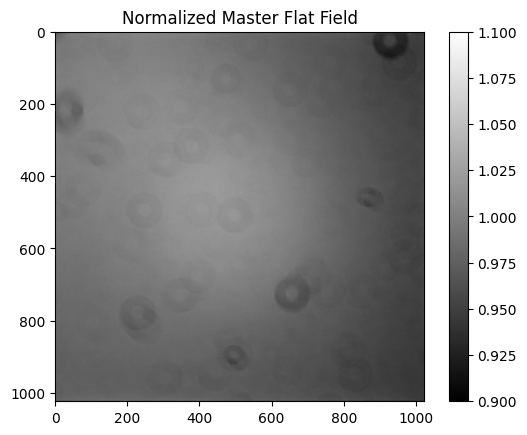

Normalized flat field saved to: ..\Tutorial_4\norm_master_flat.fits
Saved corrected image to C:\Users\misha\OneDrive\Desktop\AST_443_Resources\science_1_corrected.fits
Saved corrected image to C:\Users\misha\OneDrive\Desktop\AST_443_Resources\science_2_corrected.fits
Saved corrected image to C:\Users\misha\OneDrive\Desktop\AST_443_Resources\science_3_corrected.fits


In [14]:
# File template and index range for dark frames
dark_file_template = r"..\Tutorial_4\darks.{:08d}.DARK.FIT"
start_index_dark = 2604
end_index_dark = 2623

# Create the master dark frame
master_dark_frame, _ = create_master_dark(dark_file_template, start_index_dark, end_index_dark)

# List of science files
science_files = [
    r"..\Tutorial_4\science_1.fits",
    r"..\Tutorial_4\science_2.fits",
    r"..\Tutorial_4\science_3.fits"
]

# Subtract the master dark from each science image
for science_file in science_files:
    subtracted_image = subtract_master_dark_from_science(master_dark_frame, science_file)
    
    # Save the subtracted image to a new FITS file
    output_file = science_file.replace('.fits', '_subtracted.fits')
    fits.writeto(output_file, subtracted_image, overwrite=True)
    print(f'Subtracted image saved to: {output_file}')

# File template and index range for flat fields
flat_file_template = r"..\Tutorial_4\flats.{:08d}.FIT"
start_index_flat = 2625
end_index_flat = 2634

# Create the master flat frame
master_flat_frame, _ = create_master_flat(flat_file_template, start_index_flat, end_index_flat)

# Normalize the master flat frame and save it in the same directory as the other output files
output_directory = r"..\Tutorial_4"
norm_flat = normalize_flat_field(master_flat_frame, output_directory)

# Output file paths for the corrected images
output_paths = [
    r"C:\Users\misha\OneDrive\Desktop\AST_443_Resources\science_1_corrected.fits",
    r"C:\Users\misha\OneDrive\Desktop\AST_443_Resources\science_2_corrected.fits",
    r"C:\Users\misha\OneDrive\Desktop\AST_443_Resources\science_3_corrected.fits"
]

# Loop over each science image, divide by the master flat, and save the corrected image
for science_image_path, output_path in zip(science_files, output_paths):
    divide_by_master_flat(science_image_path.replace('.fits', '_subtracted.fits'), norm_flat, output_path)

File: ..\Tutorial_4\flats.00002625.FIT, Mean: 32406.191054344177
File: ..\Tutorial_4\flats.00002626.FIT, Mean: 32243.787157058716
File: ..\Tutorial_4\flats.00002627.FIT, Mean: 32223.986525535583
File: ..\Tutorial_4\flats.00002628.FIT, Mean: 32330.513867378235
File: ..\Tutorial_4\flats.00002629.FIT, Mean: 32345.540390968323
File: ..\Tutorial_4\flats.00002630.FIT, Mean: 32337.68927192688
File: ..\Tutorial_4\flats.00002631.FIT, Mean: 32371.462470054626
File: ..\Tutorial_4\flats.00002632.FIT, Mean: 32333.615273475647
File: ..\Tutorial_4\flats.00002633.FIT, Mean: 32273.858921051025
File: ..\Tutorial_4\flats.00002634.FIT, Mean: 32194.721994400024


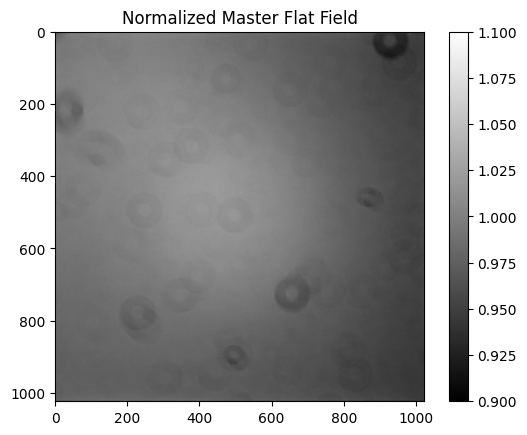

Normalized flat field saved to: ..\Tutorial_4\norm_master_flat.fits
Corrected image saved to: ..\Tutorial_4\science_combined_corrected.fits


In [15]:
# (1) Read and combine science images into a median image
def create_median_science_image(science_files):
    """
    Create a median science image by median-combining multiple science images.
    
    :param science_files: List of file paths to the science FITS files.
    :type science_files: list
    :return: Median science image (2D np.ndarray), Stack of individual science images (3D np.ndarray)
    :rtype: tuple(np.ndarray, np.ndarray)
    """
    science_images = []
    
    # Load each science image and append it to the list
    for science_file in science_files:
        with fits.open(science_file) as hdul:
            science_images.append(hdul[0].data)
    
    # Stack the images into a 3D array and compute the median across the stack (axis=0)
    stacked_images = np.stack(science_images, axis=0)
    median_science_image = np.median(stacked_images, axis=0)
    
    return median_science_image, stacked_images

# (2) Subtract the master dark frame from the median science image
def subtract_master_dark(median_science_image, master_dark_frame):
    """
    Subtract the master dark frame from the median science image.
    
    :param median_science_image: The median science image (2D np.ndarray).
    :type median_science_image: np.ndarray
    :param master_dark_frame: The master dark frame (2D np.ndarray).
    :type master_dark_frame: np.ndarray
    :return: Dark-subtracted image (2D np.ndarray)
    :rtype: np.ndarray
    """
    return median_science_image - master_dark_frame

# (3) Divide by the master flat frame
def divide_by_master_flat(subtracted_image, norm_flat):
    """
    Divide the dark-subtracted image by the normalized flat field.
    
    :param subtracted_image: Dark-subtracted science image (2D np.ndarray).
    :type subtracted_image: np.ndarray
    :param norm_flat: Normalized master flat field (2D np.ndarray).
    :type norm_flat: np.ndarray
    :return: Corrected image (2D np.ndarray)
    :rtype: np.ndarray
    """
    return subtracted_image / norm_flat

# (4) Save the corrected image to a new FITS file
def save_fits_image(image_data, output_path, header=None):
    """
    Save the corrected image as a FITS file.
    
    :param image_data: Image data to be saved (2D np.ndarray).
    :type image_data: np.ndarray
    :param output_path: Path to the output FITS file.
    :type output_path: str
    :param header: FITS header (optional).
    :type header: astropy.io.fits.Header
    """
    hdu = fits.PrimaryHDU(image_data, header=header)
    hdu.writeto(output_path, overwrite=True)
    print(f"Corrected image saved to: {output_path}")

# Main script
if __name__ == "__main__":
    # File template and index range for dark frames
    dark_file_template = r"..\Tutorial_4\darks.{:08d}.DARK.FIT"
    start_index_dark = 2604
    end_index_dark = 2623

    # Create the master dark frame
    master_dark_frame, _ = create_master_dark(dark_file_template, start_index_dark, end_index_dark)

    # List of science files
    science_files = [
        r"..\Tutorial_4\science_1.fits",
        r"..\Tutorial_4\science_2.fits",
        r"..\Tutorial_4\science_3.fits"
    ]

    # Create the median science image
    median_science_image, _ = create_median_science_image(science_files)
    
    # Subtract the master dark from the median science image
    subtracted_image = subtract_master_dark(median_science_image, master_dark_frame)
    
    # File template and index range for flat fields
    flat_file_template = r"..\Tutorial_4\flats.{:08d}.FIT"
    start_index_flat = 2625
    end_index_flat = 2634

    # Create the master flat frame
    master_flat_frame, _ = create_master_flat(flat_file_template, start_index_flat, end_index_flat)

    # Normalize the master flat frame and save it in the same directory as the other output files
    output_directory = r"..\Tutorial_4"
    norm_flat = normalize_flat_field(master_flat_frame, output_directory)

    # Divide the dark-subtracted image by the normalized master flat
    corrected_image = divide_by_master_flat(subtracted_image, norm_flat)

    # Save the corrected image to a new FITS file
    output_file = r"..\Tutorial_4\science_combined_corrected.fits"
    save_fits_image(corrected_image, output_file)

In [17]:
def get_gain(file_path):
    """
    Extract the gain from the FITS header of a science image.
    
    :param file_path: Path to the science FITS file.
    :type file_path: str
    :return: Gain value from the FITS header.
    :rtype: float
    """
    with fits.open(file_path) as hdul:
        header = hdul[0].header
        gain = header.get('EGAIN', 'No gain found')
        return gain

# List of science files
science_files = [
    r"..\Tutorial_4\science_1.fits",
    r"..\Tutorial_4\science_2.fits",
    r"..\Tutorial_4\science_3.fits"
]

# Extract and print the gain for each science image
gains = []
for science_file in science_files:
    gain = get_gain(science_file)
    gains.append(gain)
    print(f"File: {science_file}, Gain: {gain}")

# Calculate and print the combined gain (mean of individual gains)
if all(isinstance(g, (int, float)) for g in gains):
    combined_gain = sum(gains) / len(gains)
    print(f"Combined Gain (mean): {combined_gain}")
else:
    print("One or more images do not have valid gain values.")

File: ..\Tutorial_4\science_1.fits, Gain: 2.06
File: ..\Tutorial_4\science_2.fits, Gain: 2.06
File: ..\Tutorial_4\science_3.fits, Gain: 2.06
Combined Gain (mean): 2.06
